In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc, confusion_matrix
import gc
import os
import warnings

warnings.filterwarnings('ignore')

# Cấu hình chung
N_FOLDS = 5
RANDOM_STATE = 42
TARGET_COL = 'target'
ID_COL = 'object_id'

# Đường dẫn đến file features đã tạo ở bước trước
# Hãy sửa lại nếu tên file của bạn khác
TRAIN_FEAT_PATH = "features_out_data_feature_selection/train_features_all_splits.csv" 
TEST_FEAT_PATH = "features_out_data_feature_selection/test_features_all_splits.csv"

In [3]:
print("Loading data...")
# Nếu bạn lưu từng split riêng lẻ, bạn cần code để gom chúng lại.
# Ở đây giả định bạn đã gom thành 1 file tổng hoặc chạy run_all() ra dataframe.

if os.path.exists(TRAIN_FEAT_PATH):
    train_df = pd.read_csv(TRAIN_FEAT_PATH)
    test_df = pd.read_csv(TEST_FEAT_PATH)
else:
    # Nếu chưa có file tổng, hãy dùng code này để gom các file split_xx lại
    print("Merging split files...")
    import glob
    train_files = glob.glob("features_out_data_feature_selection/split_*_train_features.csv")
    test_files = glob.glob("features_out_data_feature_selection/split_*_test_features.csv")

    train_df = pd.concat([pd.read_csv(f) for f in train_files], ignore_index=True)
    test_df = pd.concat([pd.read_csv(f) for f in test_files], ignore_index=True)

# Loại bỏ các cột không dùng để train
ignore_cols = [ID_COL, TARGET_COL, 'split', 'dataset', 'fold']
features = [c for c in train_df.columns if c not in ignore_cols]

# Xử lý vô cùng (inf) nếu có
train_df = train_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.replace([np.inf, -np.inf], np.nan)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Features used: {len(features)}")

Loading data...
Train shape: (3043, 154)
Test shape: (7135, 153)
Features used: 150


In [ ]:
def objective_lgbm(trial, X, y):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': 5000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 25.0), # Quan trọng cho imbalanced
        'n_jobs': 4
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    auc_scores = []
    
    # Chỉ chạy trên 1 phần dữ liệu để tune cho nhanh (optional)
    X_sample = X.sample(frac=0.5, random_state=RANDOM_STATE) if len(X) > 20000 else X
    y_sample = y[X_sample.index]

    for idx, (train_idx, val_idx) in enumerate(cv.split(X_sample, y_sample)):
        X_train, X_val = X_sample.iloc[train_idx], X_sample.iloc[val_idx]
        y_train, y_val = y_sample.iloc[train_idx], y_sample.iloc[val_idx]

        model = lgb.train(
            param, 
            lgb.Dataset(X_train, label=y_train),
            valid_sets=[lgb.Dataset(X_val, label=y_val)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )
        preds = model.predict(X_val)
        auc_scores.append(roc_auc_score(y_val, preds))
    
    return np.mean(auc_scores)

# Bật dòng dưới đây nếu bạn muốn chạy Optuna (mất khoảng 15-30 phút)
DO_TUNING = True 

best_params_lgbm = { # Tham số mặc định tốt nếu không tune
    'learning_rate': 0.02, 'num_leaves': 31, 'max_depth': -1, 
    'scale_pos_weight': 5.0, 'n_estimators': 5000, 'metric': 'auc'
}

if DO_TUNING:
    print("--- Tuning LightGBM with Optuna ---")
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective_lgbm(trial, train_df[features], train_df[TARGET_COL]), n_trials=30)
    print("Best params:", study.best_params)
    best_params_lgbm.update(study.best_params)

In [37]:
def train_model(model_type, params, X, y, X_test):
    print(f"\nTraining {model_type}...")
    folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros(len(X_test))
    importances = pd.DataFrame()
    
    for fold, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        if model_type == 'lgbm':
            dtrain = lgb.Dataset(X_trn, label=y_trn)
            dval = lgb.Dataset(X_val, label=y_val)
            model = lgb.train(
                params, dtrain, valid_sets=[dtrain, dval],
                callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
            )
            val_pred = model.predict(X_val, num_iteration=model.best_iteration)
            test_pred = model.predict(X_test, num_iteration=model.best_iteration)

            fold_imp = pd.DataFrame()
            fold_imp["feature"] = X.columns
            fold_imp["importance"] = model.feature_importance(importance_type='gain')
            fold_imp["fold"] = fold + 1
            importances = pd.concat([importances, fold_imp], axis=0)

            
            
        elif model_type == 'xgb':
            dtrain = xgb.DMatrix(X_trn, label=y_trn)
            dval = xgb.DMatrix(X_val, label=y_val)
            dtest = xgb.DMatrix(X_test)
            model = xgb.train(
                params, dtrain, num_boost_round=5000,
                evals=[(dtrain, 'train'), (dval, 'val')],
                early_stopping_rounds=100, verbose_eval=False
            )
            val_pred = model.predict(dval)
            test_pred = model.predict(dtest)
            
        elif model_type == 'cat':
            model = CatBoostClassifier(**params)
            model.fit(
                X_trn, y_trn, eval_set=(X_val, y_val),
                early_stopping_rounds=100, verbose=False
            )
            val_pred = model.predict_proba(X_val)[:, 1]
            test_pred = model.predict_proba(X_test)[:, 1]
            
        oof_preds[val_idx] = val_pred
        test_preds += test_pred / N_FOLDS
        
        score = roc_auc_score(y_val, val_pred)

        
    print(f"{model_type.upper()} Overall AUC: {roc_auc_score(y, oof_preds):.5f}")
    return oof_preds, test_preds, importances

In [38]:
# 1. LightGBM
params_lgbm = best_params_lgbm.copy()
params_lgbm['verbose'] = -1
oof_lgb, pred_lgb, imp_lgb = train_model('lgbm', params_lgbm, train_df[features], train_df[TARGET_COL], test_df[features])

# 2. XGBoost (Tham số chuẩn cho Imbalanced)
params_xgb = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 5, # Chỉnh cái này nếu muốn bắt nhiều TDE hơn
    'tree_method': 'hist', # Tăng tốc
    'nthread': 4,
    'random_state': RANDOM_STATE
}
oof_xgb, pred_xgb, _ = train_model('xgb', params_xgb, train_df[features], train_df[TARGET_COL], test_df[features])

# 3. CatBoost (Mạnh mẽ với nhiễu)
params_cat = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.03,
    'iterations': 5000,
    'depth': 6,
    'auto_class_weights': 'Balanced', # Tự động cân bằng lớp
    'verbose': False,
    'random_seed': RANDOM_STATE
}
oof_cat, pred_cat, _ = train_model('cat', params_cat, train_df[features], train_df[TARGET_COL], test_df[features])




Training lgbm...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	training's auc: 1	valid_1's auc: 0.889695
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	training's auc: 1	valid_1's auc: 0.952965
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	training's auc: 1	valid_1's auc: 0.916983
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	training's auc: 1	valid_1's auc: 0.968257
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[33]	training's auc: 1	valid_1's auc: 0.940087
LGBM Overall AUC: 0.93292

Training xgb...
XGB Overall AUC: 0.93336

Training cat...
CAT Overall AUC: 0.94970


In [39]:
from scipy.optimize import minimize

# Hàm mục tiêu: Tối đa hóa AUC (bằng cách tối thiểu hóa -AUC)
def minimize_auc(weights):
    # Chuẩn hóa weights để tổng = 1
    weights = np.array(weights)
    weights /= weights.sum()
    
    # Tính OOF tổng hợp
    final_oof_scipy = (weights[0] * oof_lgb + 
                       weights[1] * oof_xgb + 
                       weights[2] * oof_cat)
    
    return -roc_auc_score(train_df[TARGET_COL], final_oof_scipy)

# Tìm trọng số tối ưu
init_weights = [0.33, 0.33, 0.33]
res = minimize(minimize_auc, init_weights, method='Nelder-Mead', tol=1e-5)

best_weights = res.x / res.x.sum()
print(f"\n🚀 Trọng số tối ưu tìm được: LGBM={best_weights[0]:.2f}, XGB={best_weights[1]:.2f}, CAT={best_weights[2]:.2f}")

# Áp dụng trọng số mới
final_oof = (best_weights[0] * oof_lgb + 
             best_weights[1] * oof_xgb + 
             best_weights[2] * oof_cat)

final_pred = (best_weights[0] * pred_lgb + 
              best_weights[1] * pred_xgb + 
              best_weights[2] * pred_cat)

print(f"✅ Optimized Ensemble OOF AUC: {roc_auc_score(train_df[TARGET_COL], final_oof):.5f}")


🚀 Trọng số tối ưu tìm được: LGBM=0.21, XGB=0.26, CAT=0.53
✅ Optimized Ensemble OOF AUC: 0.95259


✅ Overall ROC-AUC: 0.95259
✅ Best Threshold: 0.2771
✅ Max Train F1-Score: 0.5740

===== CONFUSION MATRIX =====
[[2807   88]
 [  53   95]]

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

     Non-TDE       0.98      0.97      0.98      2895
         TDE       0.52      0.64      0.57       148

    accuracy                           0.95      3043
   macro avg       0.75      0.81      0.77      3043
weighted avg       0.96      0.95      0.96      3043



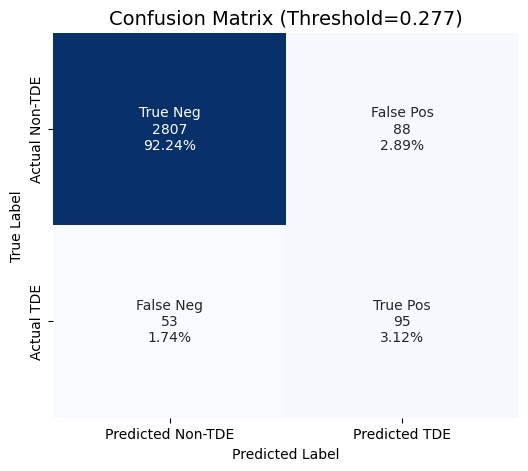

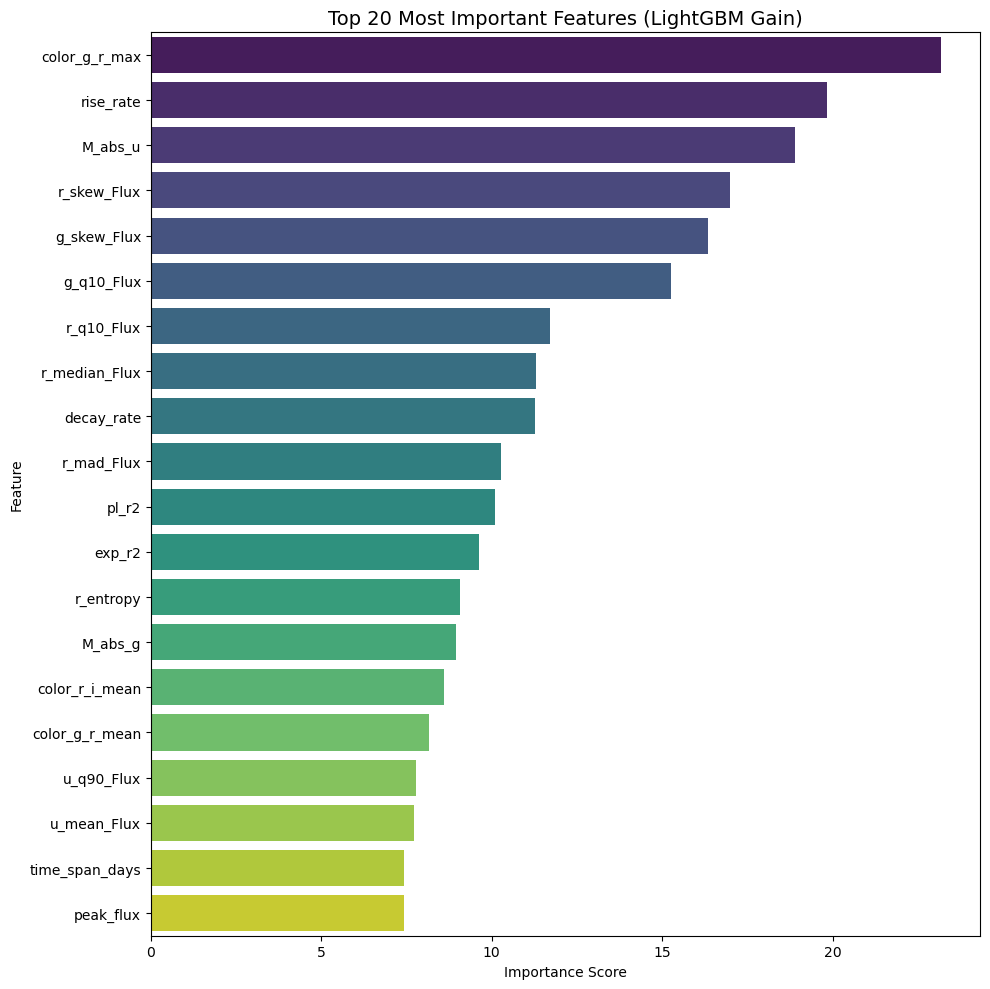


Top 5 Features:
1. color_g_r_max (23.17)
2. rise_rate (19.83)
3. M_abs_u (18.89)
4. r_skew_Flux (16.98)
5. g_skew_Flux (16.34)

Số lượng TDE dự đoán trong Test: 458
Đã lưu: submission_ensemble_final_feature_selection.csv


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# ==============================================================================
# ĐÁNH GIÁ TOÀN DIỆN (EVALUATION REPORT)
# ==============================================================================

# 1. AUC Tổng thể
auc_score = roc_auc_score(train_df[TARGET_COL], final_oof)
print(f"✅ Overall ROC-AUC: {auc_score:.5f}")

# 2. Tìm Ngưỡng Tối Ưu (Best Threshold) theo F1-Score
precisions, recalls, thresholds = precision_recall_curve(train_df[TARGET_COL], final_oof)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"✅ Best Threshold: {best_thresh:.4f}")
print(f"✅ Max Train F1-Score: {best_f1:.4f}")

# 3. Confusion Matrix Report
y_pred_binary = (final_oof >= best_thresh).astype(int)
cm = confusion_matrix(train_df[TARGET_COL], y_pred_binary)

print("\n===== CONFUSION MATRIX =====")
print(cm)

print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(train_df[TARGET_COL], y_pred_binary, target_names=['Non-TDE', 'TDE']))

# 4. Vẽ Confusion Matrix
plt.figure(figsize=(6, 5))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-TDE', 'Predicted TDE'],
            yticklabels=['Actual Non-TDE', 'Actual TDE'])
plt.title(f'Confusion Matrix (Threshold={best_thresh:.3f})', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 5. Top 20 Features Quan Trọng Nhất (Dựa trên LightGBM)
if 'imp_lgb' in globals() and not imp_lgb.empty:
    plt.figure(figsize=(10, 10))
    # Tính trung bình importance qua các fold
    avg_imp = imp_lgb.groupby("feature")["importance"].mean().sort_values(ascending=False).head(20).reset_index()
    
    sns.barplot(x="importance", y="feature", data=avg_imp, palette="viridis")
    plt.title('Top 20 Most Important Features (LightGBM Gain)', fontsize=14)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 Features:")
    for i, row in avg_imp.head(5).iterrows():
        print(f"{i+1}. {row['feature']} ({row['importance']:.2f})")
else:
    print("⚠️ Không tìm thấy dữ liệu Feature Importance. Hãy chắc chắn bạn đã chạy bước Train LightGBM.")

# 6. Lưu Submission
submission = pd.DataFrame()
submission['object_id'] = test_df['object_id']
submission['pred_prob'] = final_pred
submission['target'] = (final_pred >= best_thresh).astype(int)

n_tde = submission['target'].sum()
print(f"\nSố lượng TDE dự đoán trong Test: {n_tde}")

submission[['object_id', 'target']].to_csv("submission_ensemble_final_feature_selection.csv", index=False)
print("Đã lưu: submission_ensemble_final_feature_selection.csv")